In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/home/ubuntu/sustaingym


# Imports

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed

from sustaingym.algorithms.evcharging.base_algorithm import SelectiveChargingAlgorithm, GreedyAlgorithm, PPOAlgorithm, RandomAlgorithm
from sustaingym.envs.evcharging.ev_charging import EVChargingEnv
from sustaingym.envs.evcharging.ev_charging import EVChargingEnv
from sustaingym.envs.evcharging.event_generation import RealTraceGenerator

In [11]:
from datetime import datetime, timedelta
import pandas as pd

DATE_FORMAT = "%Y-%m-%d"

date_range = ('2018-11-05', '2018-11-11')

generator = RealTraceGenerator(site='caltech', date_range=date_range, sequential=True, period=5)
eval_env = EVChargingEnv(generator, action_type='discrete')

eval_env.reset()

# algs = [SelectiveChargingAlgorithm(rate=1.0), SelectiveChargingAlgorithm(rate=2.0), GreedyAlgorithm(), RandomAlgorithm()]
algs = [GreedyAlgorithm(eval_env)]
def collect_rewards(algs):
    begin = datetime.strptime(date_range[0], DATE_FORMAT)
    end = datetime.strptime(date_range[1], DATE_FORMAT)
    days_diff = end - begin
    num_days_sim = days_diff.days + 1

    results = {}
    for alg in algs:
        print(f"Running {alg.name}")
        results[alg] = alg.run(num_days_sim)
    results = {alg.name: reward for alg, reward in results.items()}

    results['dates'] = [begin + timedelta(days=i) for i in range(num_days_sim)]

    results = pd.DataFrame(results)
    results.set_index('dates', inplace=True)
    return results

heuristics_rewards = collect_rewards(algs)
heuristics_rewards

Running optimal greedy


,optimal greedy
dates,
2018-11-05,1.490157
2018-11-06,0.778609
2018-11-07,-0.096580
2018-11-08,0.184404
2018-11-09,-0.874359
2018-11-10,0.246199
2018-11-11,2.118542


In [10]:
heuristics_rewards = collect_rewards(algs)
heuristics_rewards

Running optimal greedy


,optimal greedy
dates,
2018-11-05,1.435699
2018-11-06,0.763045
2018-11-07,-0.394593
2018-11-08,-0.009660
2018-11-09,-0.874359
2018-11-10,0.240532
2018-11-11,2.047478


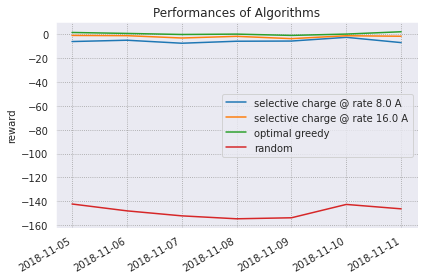

In [35]:
plt.title("Performances of Algorithms")
for col in heuristics_rewards.columns:
    plt.plot(heuristics_rewards[col], label=col)
plt.ylabel('reward')
plt.gcf().autofmt_xdate()
plt.legend()
plt.tight_layout()
plt.show()

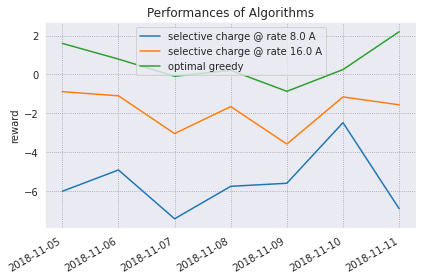

In [37]:
plt.title("Performances of Algorithms")
for col in heuristics_rewards.columns:
    if col == 'random':
        continue
    plt.plot(heuristics_rewards[col], label=col)
plt.ylabel('reward')
plt.gcf().autofmt_xdate()
plt.legend()
plt.tight_layout()
plt.show()

# Train a PPO Agent

In [38]:
# Create train environment, same parameters as test environment
generator = RealTraceGenerator(site='caltech', date_range=date_range, sequential=True, period=5)
train_env = EVChargingEnv(generator, action_type='discrete')

model = PPO('MultiInputPolicy', train_env, verbose=0)
rl_algo = PPOAlgorithm(model)

trained_rewards = {}
num_steps = 0
timesteps = 25_000
for _ in range(10):
    trained_rewards[num_steps] = collect_rewards(eval_env, [rl_algo])
    display(trained_rewards[num_steps])
    num_steps += timesteps
    model.learn(total_timesteps=timesteps)
    print("num timesteps: ", num_steps)

trained_rewards[num_steps] = collect_rewards(eval_env, [rl_algo])
display(trained_rewards[num_steps])


Running PPO algorithm


,PPO algorithm
dates,
2018-11-05,-146.202383
2018-11-06,-149.809635
2018-11-07,-148.572783
2018-11-08,-152.360336
2018-11-09,-147.172390
2018-11-10,-146.234735
2018-11-11,-149.053592


num timesteps:  25000
Running PPO algorithm


,PPO algorithm
dates,
2018-11-05,-129.505325
2018-11-06,-127.230584
2018-11-07,-132.280453
2018-11-08,-125.482125
2018-11-09,-140.030269
2018-11-10,-133.723937
2018-11-11,-131.775377


num timesteps:  50000
Running PPO algorithm


,PPO algorithm
dates,
2018-11-05,-93.915142
2018-11-06,-100.695504
2018-11-07,-106.531250
2018-11-08,-95.389322
2018-11-09,-113.281039
2018-11-10,-100.747747
2018-11-11,-99.447916


num timesteps:  75000
Running PPO algorithm


,PPO algorithm
dates,
2018-11-05,-48.686062
2018-11-06,-53.217510
2018-11-07,-57.222276
2018-11-08,-50.118587
2018-11-09,-68.361313
2018-11-10,-44.008972
2018-11-11,-47.141317


num timesteps:  100000
Running PPO algorithm


,PPO algorithm
dates,
2018-11-05,-26.254646
2018-11-06,-31.504500
2018-11-07,-32.244660
2018-11-08,-24.632610
2018-11-09,-47.897060
2018-11-10,-22.804781
2018-11-11,-24.260940


num timesteps:  125000
Running PPO algorithm


,PPO algorithm
dates,
2018-11-05,-17.894057
2018-11-06,-18.326513
2018-11-07,-20.302390
2018-11-08,-18.780779
2018-11-09,-34.782752
2018-11-10,-16.841110
2018-11-11,-19.413234


num timesteps:  150000
Running PPO algorithm


,PPO algorithm
dates,
2018-11-05,-16.087201
2018-11-06,-16.467737
2018-11-07,-19.077247
2018-11-08,-16.527818
2018-11-09,-30.676594
2018-11-10,-14.947549
2018-11-11,-17.917124


num timesteps:  175000
Running PPO algorithm


,PPO algorithm
dates,
2018-11-05,-15.745402
2018-11-06,-15.829673
2018-11-07,-18.209531
2018-11-08,-15.622246
2018-11-09,-24.957621
2018-11-10,-14.080211
2018-11-11,-16.657568


num timesteps:  200000
Running PPO algorithm


,PPO algorithm
dates,
2018-11-05,-15.402192
2018-11-06,-14.173378
2018-11-07,-16.938756
2018-11-08,-15.756555
2018-11-09,-18.968741
2018-11-10,-13.856502
2018-11-11,-16.489473


num timesteps:  225000
Running PPO algorithm


,PPO algorithm
dates,
2018-11-05,-15.636396
2018-11-06,-14.366632
2018-11-07,-16.647981
2018-11-08,-15.824419
2018-11-09,-20.973585
2018-11-10,-14.438238
2018-11-11,-16.644529


num timesteps:  250000
Running PPO algorithm


,PPO algorithm
dates,
2018-11-05,-14.872799
2018-11-06,-13.921198
2018-11-07,-16.301511
2018-11-08,-15.512134
2018-11-09,-17.384474
2018-11-10,-13.831456
2018-11-11,-15.222822


In [39]:
model.save("ppo_agent_scheduler")

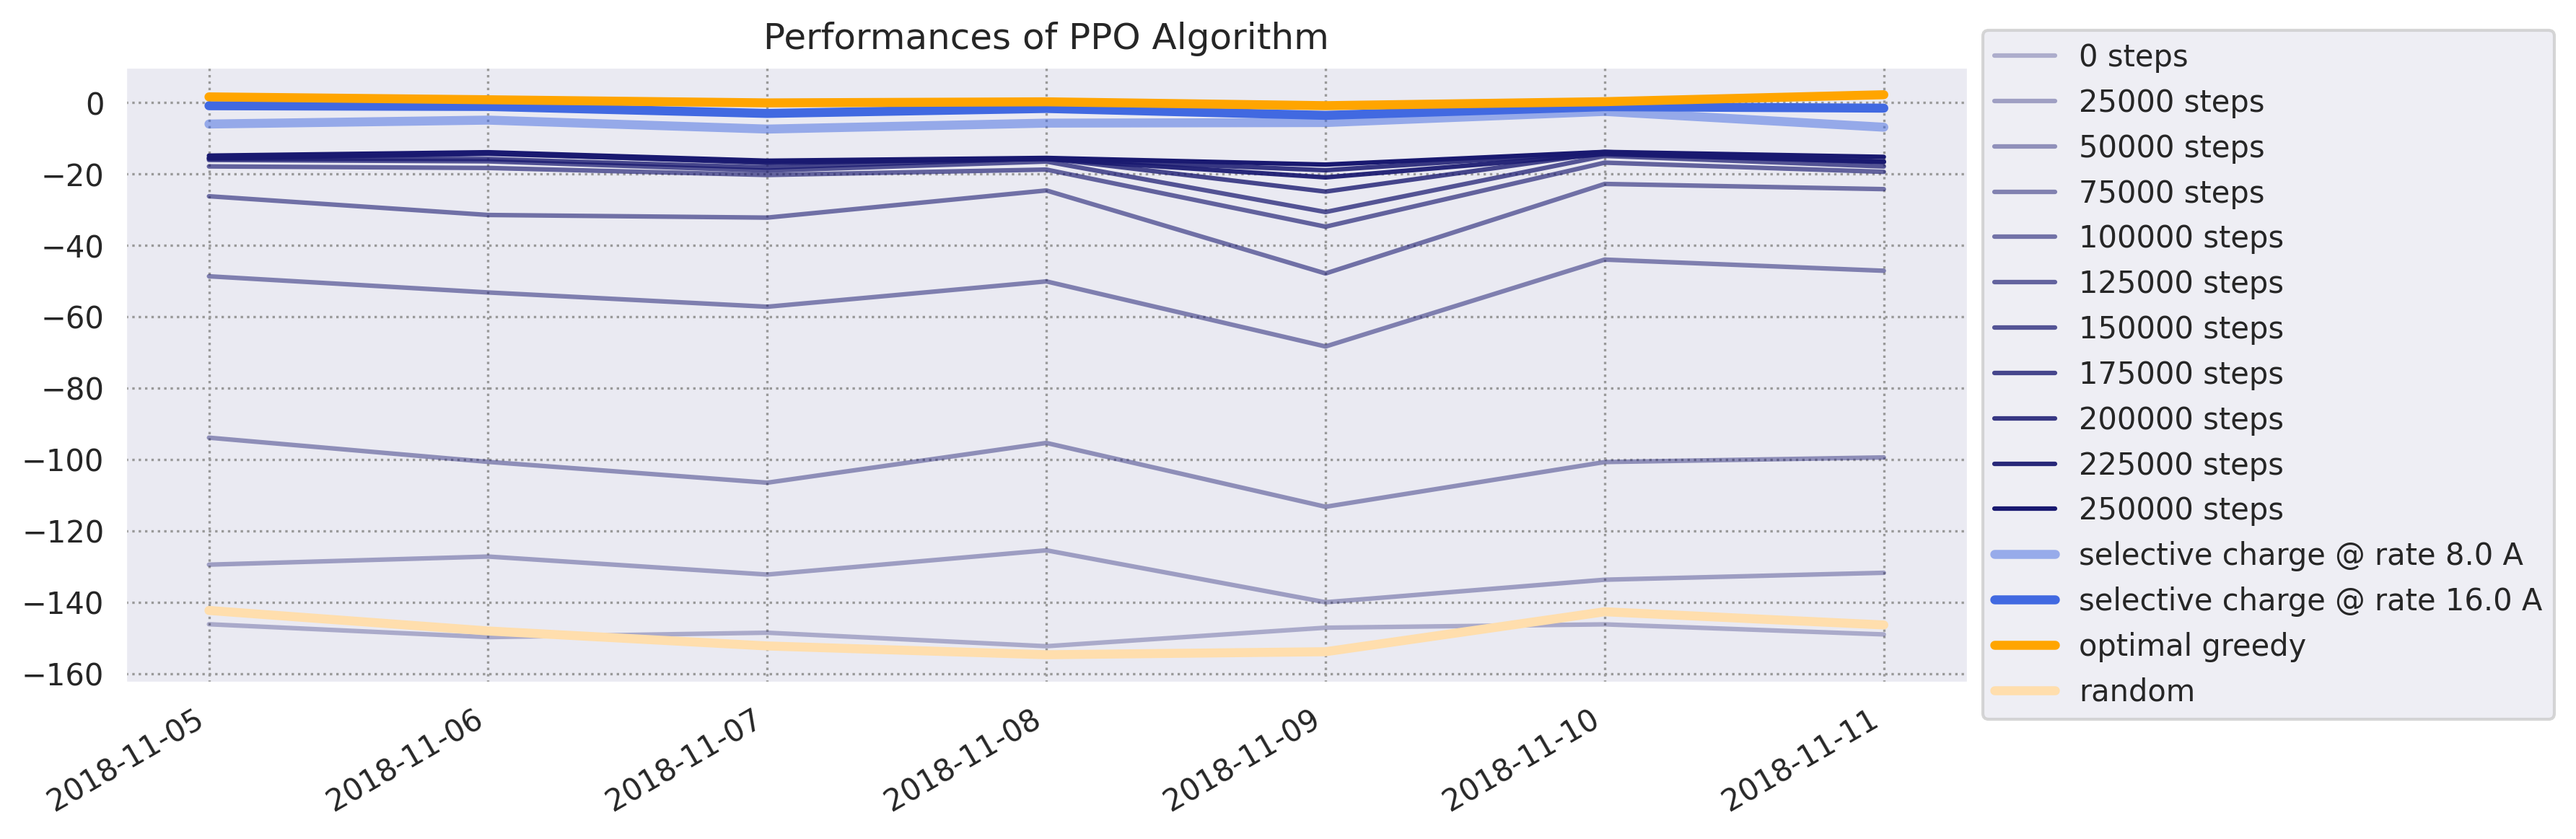

In [42]:
plt.figure(figsize=(12, 4), dpi=300)

training_results = pd.concat([trained_rewards[i * timesteps] for i in range(11)], axis=1)
training_results.columns = [f"{i * timesteps} steps" for i in range(11)]
training_results

all_results = pd.concat((training_results, heuristics_rewards), axis=1)

plt.title("Performances of PPO Algorithm")
for col in all_results.columns:
    if 'steps' in col:
        alpha = 0.3 + 0.7 * int(col.split(' ')[0]) / 250000
        plt.plot(all_results[col], label=col, alpha=alpha, color='midnightblue')
    elif 'charge' in col and '8.0' in col:
        plt.plot(all_results[col], label=col, color='royalblue', alpha=0.5, lw=3.)
    elif 'charge' in col and '16.0' in col:
        plt.plot(all_results[col], label=col, color='royalblue', alpha=1.0, lw=3.)
    elif 'random' in col:
        plt.plot(all_results[col], label=col, color='navajowhite', lw=3.)
    else:
        plt.plot(all_results[col], label=col, color='orange', lw=3.)
plt.gcf().autofmt_xdate()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [43]:
trained_rewards.keys()

dict_keys([0, 25000, 50000, 75000, 100000, 125000, 150000, 175000, 200000, 225000, 250000])

In [44]:
num_steps = 250_000
timesteps = 25_000
for _ in range(10):
    num_steps += timesteps
    print("num timesteps: ", num_steps)
    model.learn(total_timesteps=timesteps)
    trained_rewards[num_steps] = collect_rewards(eval_env, [rl_algo])
    display(trained_rewards[num_steps])


num timesteps:  275000
Running PPO algorithm


,PPO algorithm
dates,
2018-11-05,-14.587776
2018-11-06,-13.025333
2018-11-07,-16.416512
2018-11-08,-14.724763
2018-11-09,-16.351511
2018-11-10,-12.758596
2018-11-11,-15.891102


num timesteps:  300000
Running PPO algorithm


,PPO algorithm
dates,
2018-11-05,-15.098368
2018-11-06,-13.437099
2018-11-07,-16.048527
2018-11-08,-15.505225
2018-11-09,-17.110532
2018-11-10,-13.008919
2018-11-11,-15.341499


num timesteps:  325000
Running PPO algorithm


,PPO algorithm
dates,
2018-11-05,-14.835340
2018-11-06,-13.590407
2018-11-07,-16.181821
2018-11-08,-14.553034
2018-11-09,-16.112669
2018-11-10,-12.544147
2018-11-11,-15.598068


num timesteps:  350000
Running PPO algorithm


,PPO algorithm
dates,
2018-11-05,-14.682769
2018-11-06,-13.467369
2018-11-07,-15.575325
2018-11-08,-14.965332
2018-11-09,-15.443742
2018-11-10,-12.582497
2018-11-11,-15.723708


num timesteps:  375000
Running PPO algorithm


,PPO algorithm
dates,
2018-11-05,-14.811276
2018-11-06,-12.777725
2018-11-07,-15.151207
2018-11-08,-14.953949
2018-11-09,-15.034273
2018-11-10,-12.260596
2018-11-11,-15.199452


num timesteps:  400000
Running PPO algorithm


,PPO algorithm
dates,
2018-11-05,-15.324121
2018-11-06,-13.413465
2018-11-07,-15.003835
2018-11-08,-15.072605
2018-11-09,-14.780526
2018-11-10,-12.785340
2018-11-11,-14.882182


num timesteps:  425000
Running PPO algorithm


,PPO algorithm
dates,
2018-11-05,-14.645718
2018-11-06,-12.163208
2018-11-07,-14.557869
2018-11-08,-14.327163
2018-11-09,-14.250128
2018-11-10,-12.198028
2018-11-11,-14.589388


num timesteps:  450000
Running PPO algorithm


,PPO algorithm
dates,
2018-11-05,-13.660442
2018-11-06,-11.822471
2018-11-07,-14.417468
2018-11-08,-13.864353
2018-11-09,-14.104692
2018-11-10,-11.536673
2018-11-11,-13.973958


num timesteps:  475000
Running PPO algorithm


,PPO algorithm
dates,
2018-11-05,-13.826147
2018-11-06,-12.104125
2018-11-07,-14.717115
2018-11-08,-14.213120
2018-11-09,-13.374128
2018-11-10,-10.875929
2018-11-11,-14.205599


num timesteps:  500000
Running PPO algorithm


,PPO algorithm
dates,
2018-11-05,-13.617702
2018-11-06,-12.037804
2018-11-07,-13.809519
2018-11-08,-14.405556
2018-11-09,-13.212128
2018-11-10,-11.670006
2018-11-11,-14.778593


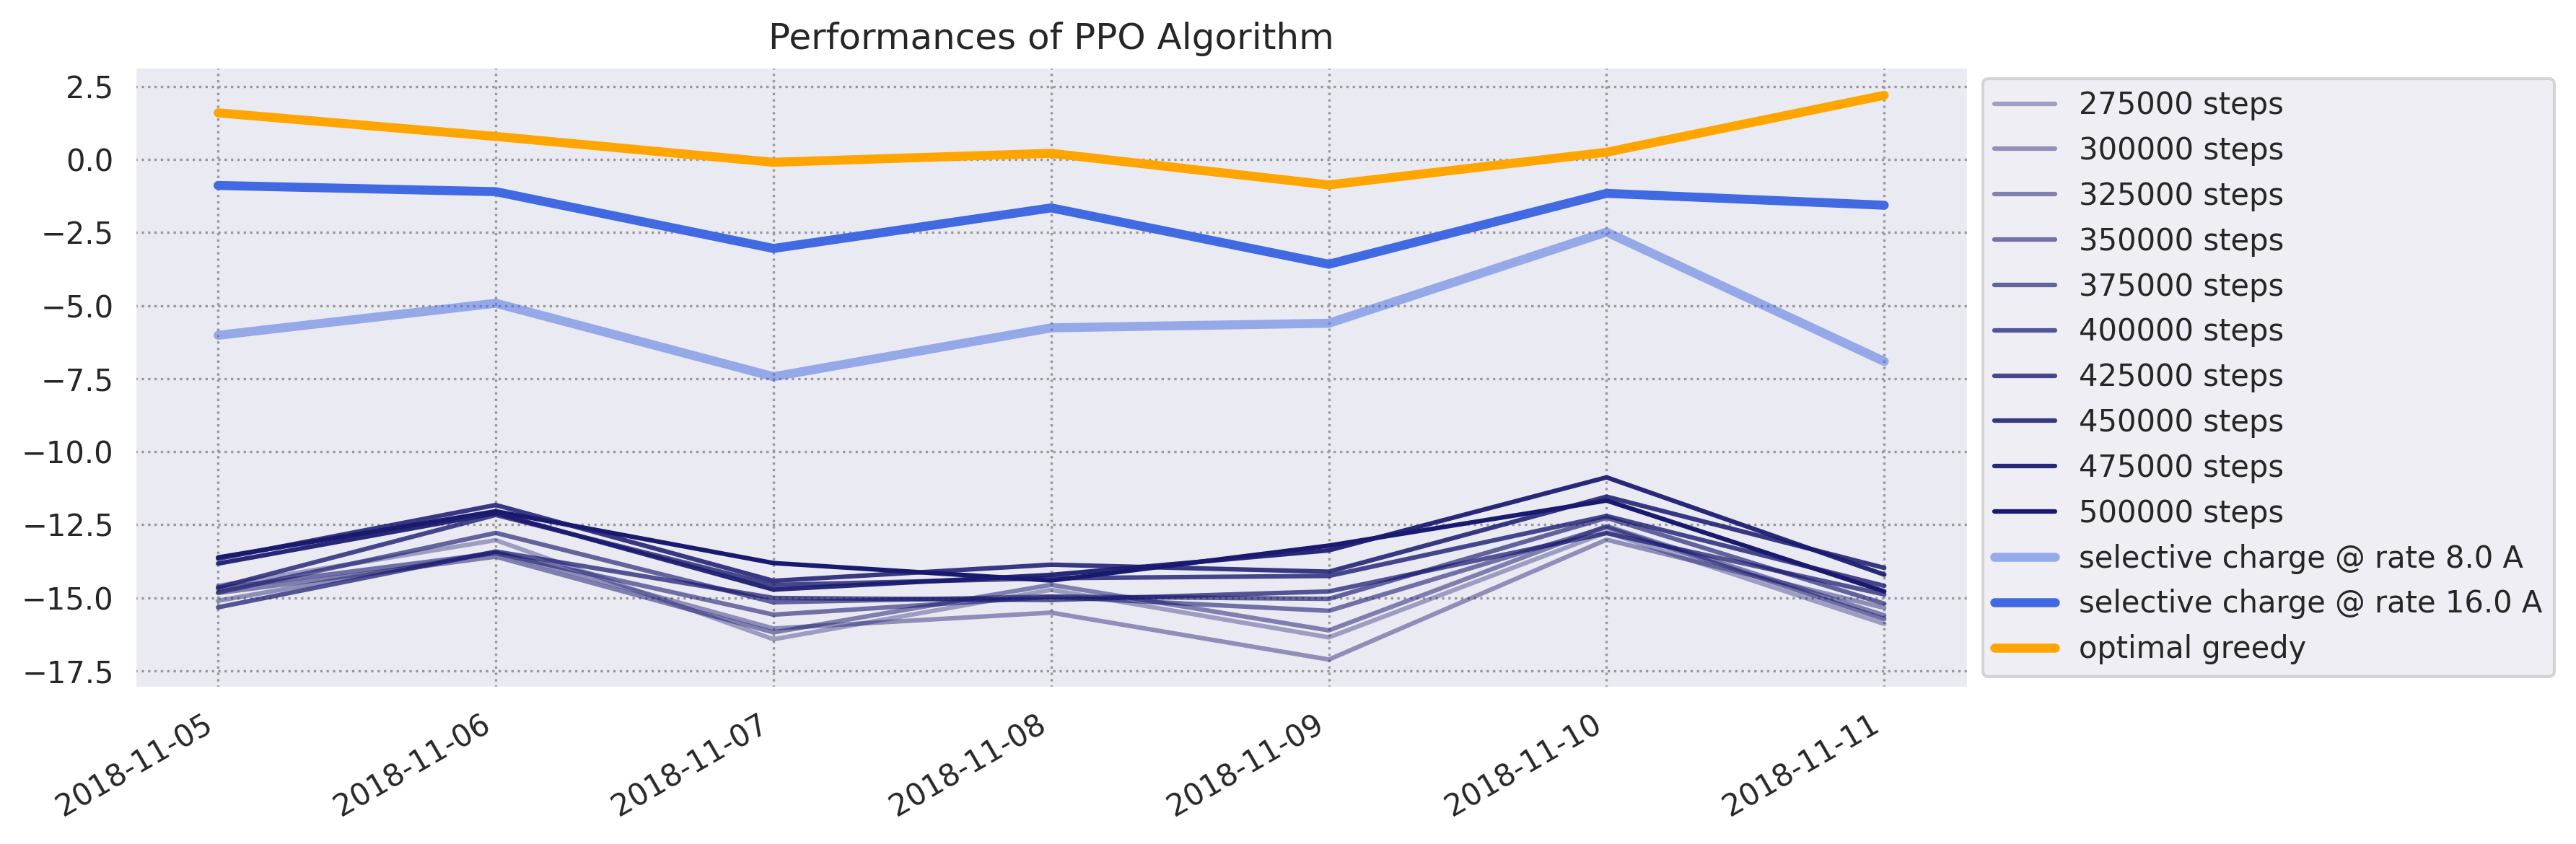

In [46]:
plt.figure(figsize=(12, 4), dpi=300)

training_results = pd.concat([trained_rewards[i * timesteps] for i in range(11, 21)], axis=1)
training_results.columns = [f"{i * timesteps} steps" for i in range(11, 21)]
training_results

all_results = pd.concat((training_results, heuristics_rewards), axis=1)

plt.title("Performances of PPO Algorithm")
for col in all_results.columns:
    if 'steps' in col:
        alpha = 0.3 + 0.7 * (int(col.split(' ')[0]) - 250_000) / 250000
        plt.plot(all_results[col], label=col, alpha=alpha, color='midnightblue')
    elif 'charge' in col and '8.0' in col:
        plt.plot(all_results[col], label=col, color='royalblue', alpha=0.5, lw=3.)
    elif 'charge' in col and '16.0' in col:
        plt.plot(all_results[col], label=col, color='royalblue', alpha=1.0, lw=3.)
    elif 'random' in col:
        continue
    else:
        plt.plot(all_results[col], label=col, color='orange', lw=3.)
plt.gcf().autofmt_xdate()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [47]:
model.save("ppo_agent_scheduler_500k_timesteps")